Train shape: (9864, 58)  y: (9864,)
Test shape : (2466, 58)  y: (2466,)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best RF params: {'class_weight': {0: 1, 1: 3}, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 400}
Best CV PR-AUC: 0.348

Best RF model object:
RandomForestClassifier(class_weight={0: 1, 1: 3}, max_features=0.5,
                       min_samples_leaf=5, n_estimators=400, n_jobs=-1,
                       random_state=42)

Best threshold by F1 (CV on training): t = 0.30, F1 = 0.409

Evaluation at threshold 0.50
ROC-AUC: 0.74
PR-AUC : 0.326
Confusion matrix:
 [[1970  114]
 [ 311   71]]
              precision    recall  f1-score   support

       False      0.864     0.945     0.903      2084
        True      0.384     0.186     0.250       382

    accuracy                          0.828      2466
   macro avg      0.624     0.566     0.577      2466
weighted avg      0.789     0.828     0.802      2466


Evaluation at best threshold (0.30)


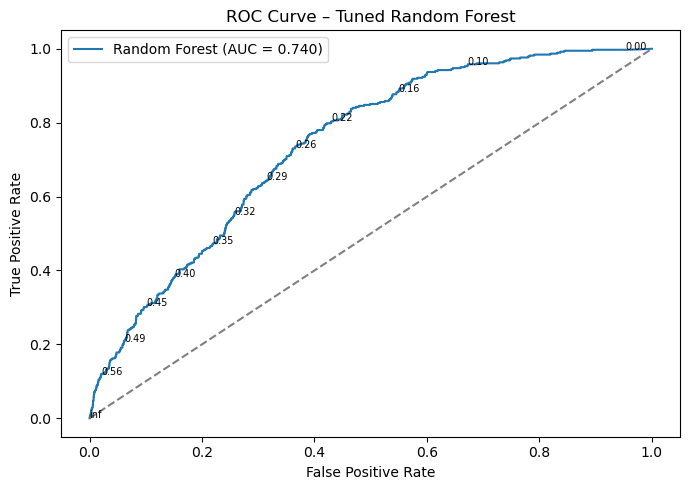

['ExitRates', 'ProductRelated_Duration', 'Administrative_Duration']

Top 15 feature importances (Random Forest):
ExitRates                        0.254150
ProductRelated_Duration          0.191736
ProductRelated                   0.113229
Administrative_Duration          0.098259
BounceRates                      0.079193
Administrative                   0.053134
Informational_Duration           0.030217
VisitorType_Returning_Visitor    0.018043
TrafficType_2                    0.017506
Informational                    0.014740
Weekend                          0.014618
OperatingSystems_2               0.014369
Browser_2                        0.012350
OperatingSystems_3               0.010196
Region_3                         0.009236
dtype: float64


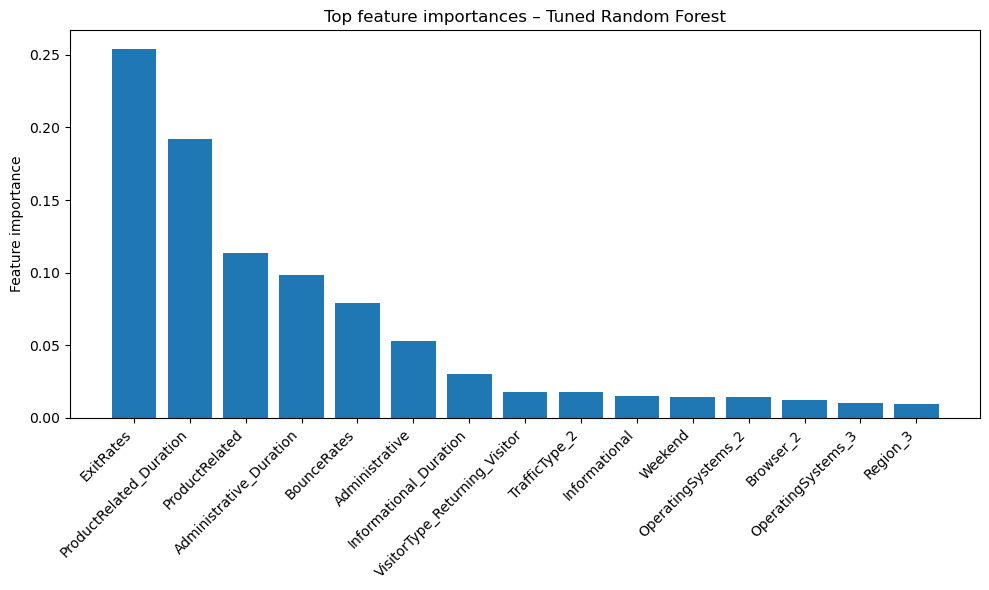

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict 
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    f1_score,
    roc_curve
)

X_train = pd.read_csv("../Data/Processed/X_train.csv")
X_test  = pd.read_csv("../Data/Processed/X_test.csv")
y_train = pd.read_csv("../Data/Processed/y_train.csv").values.ravel()
y_test  = pd.read_csv("../Data/Processed/y_test.csv").values.ravel()

print("Train shape:", X_train.shape, " y:", y_train.shape)
print("Test shape :", X_test.shape,  " y:", y_test.shape)

param_grid = {
    "n_estimators": [200, 400],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt", 0.5],
    "class_weight": ["balanced", {0: 1, 1: 3}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="average_precision",   
    cv=cv,
    n_jobs=-1,
    verbose=1,                  
    refit=True
)

grid.fit(X_train, y_train)

rf = grid.best_estimator_


print("Best RF params:", grid.best_params_)
print("Best CV PR-AUC:", round(grid.best_score_, 3))
print("\nBest RF model object:")
print(rf)  


y_proba_cv = cross_val_predict(rf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

thresholds = np.linspace(0.05, 0.50, 10)
best_t, best_f1 = None, -1
for t in thresholds:
    preds = (y_proba_cv >= t).astype(int)
    f1 = f1_score(y_train, preds, zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"\nBest threshold by F1 (CV on training): t = {best_t:.2f}, F1 = {best_f1:.3f}")

y_proba = rf.predict_proba(X_test)[:, 1]

print("\nEvaluation at threshold 0.50")
y_pred_05 = (y_proba >= 0.5).astype(int)
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("PR-AUC :", round(average_precision_score(y_test, y_proba), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_05))
print(classification_report(y_test, y_pred_05, digits=3))

print(f"\nEvaluation at best threshold ({best_t:.2f})")
y_pred_best = (y_proba >= best_t).astype(int)
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("PR-AUC :", round(average_precision_score(y_test, y_proba), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=3))

# ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
auc_value = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
step = max(1, len(roc_thresholds) // 12)
for i in range(0, len(roc_thresholds), step):
    plt.text(fpr[i], tpr[i], f"{roc_thresholds[i]:.2f}", fontsize=7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

#  Feature importance 


print([c for c in ["ExitRates", "ProductRelated_Duration", "Administrative_Duration"] if c in X_train.columns])

top_features = (
    pd.Series(rf.feature_importances_, index=X_train.columns)
    .sort_values(ascending=False)
)

print("\nTop 15 feature importances (Random Forest):")
print(top_features.head(15))
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:15]  # top 15

plt.figure(figsize=(10, 6))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), X_train.columns[idx], rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Top feature importances – Tuned Random Forest")
plt.tight_layout()
plt.show()